In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.5MB/s 
     |████████████████████████████████| 194kB 12.8MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 1.0MB 13.8MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 92kB 7.9MB/s 
     |████████████████████████████████| 40kB 5.4MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 2.6MB 24.6MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

[[chapter_production]]

In [15]:
key = os.environ.get('AZURE_SEARCH_KEY', 'c4a3147433a046638b4fb70fbe6ac87a')

In [16]:
search_images_bing

<function fastbook.search_images_bing>

In [20]:
results = search_images_bing(key, 'persian cat')
ims = results.attrgot('content_url')
len(ims)

150

In [19]:
results

(#150) [<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7fe72b4f94a8>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7fe72b4f94e0>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7fe72b4f9588>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7fe72b4f9630>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7fe72b4f96d8>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7fe72b4f9780>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7fe72b4f9828>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7fe72b4f98d0>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7fe72b4f9978>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object a

We've successfully downloaded the URLs of 150 grizzly bears (or, at least, images that Bing Image Search finds for that search term). Let's look at one:

In [21]:
#hide
ims = ['https://th.bing.com/th/id/AMMS_7bff0246a7b2a3dc18a75fbd1b439ccd?w=169&h=194&c=7&o=5&pid=1.7']

In [22]:
dest = '/content/gdrive//My Drive/Colab Notebooks/images/pers.jpg'
download_url(ims[0], dest)

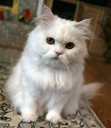

In [23]:
im = Image.open(dest)
im.to_thumb(128,128)

In [24]:
cats_types = 'persian','siamese','bengal'
path = Path('cats')

In [25]:
if not path.exists():
    path.mkdir()
    for o in cats_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} cat')
        download_images(dest, urls=results.attrgot('content_url'))

In [26]:
fns = get_image_files(path)
fns

(#450) [Path('cats/persian/00000035.jpg'),Path('cats/persian/00000030.jpg'),Path('cats/persian/00000047.jpg'),Path('cats/persian/00000023.jpg'),Path('cats/persian/00000040.jpg'),Path('cats/persian/00000039.jpg'),Path('cats/persian/00000038.jpg'),Path('cats/persian/00000066.jpeg'),Path('cats/persian/00000103.jpg'),Path('cats/persian/00000010.jpg')...]

In [27]:
failed = verify_images(fns)
failed

(#4) [Path('cats/persian/00000104.jpg'),Path('cats/bengal/00000014.jpg'),Path('cats/bengal/00000131.jpg'),Path('cats/bengal/00000019.jpg')]

In [28]:
failed.map(Path.unlink);

In [29]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [30]:
dls = cats.dataloaders(path)

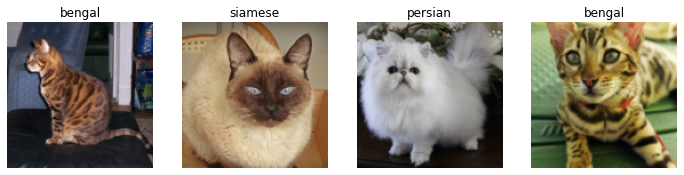

In [31]:
dls.valid.show_batch(max_n=4, nrows=1)

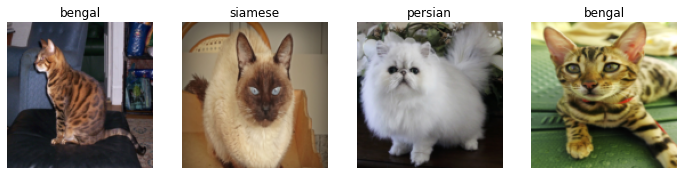

In [32]:
cats = cats.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = cats.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

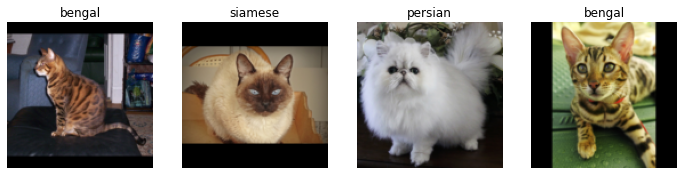

In [33]:
cats = cats.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = cats.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

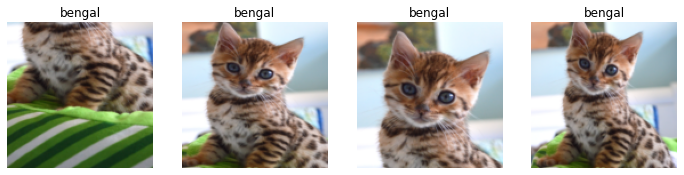

In [34]:
cats = cats.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

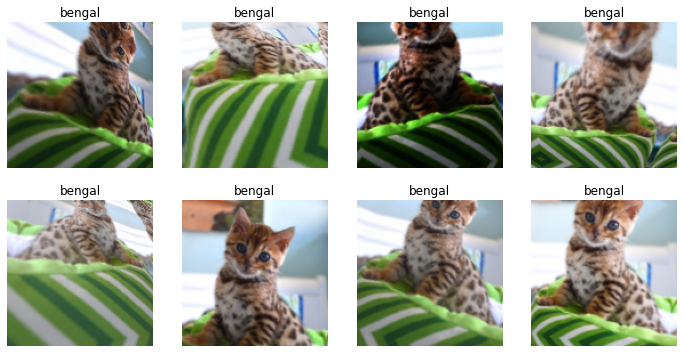

In [35]:
cats = cats.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [36]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cats.dataloaders(path)

In [37]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.252666,0.051206,0.033708,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.161716,0.049161,0.011236,00:11
1,0.137959,0.066697,0.011236,00:11
2,0.105568,0.076048,0.011236,00:12
3,0.105034,0.083398,0.011236,00:12


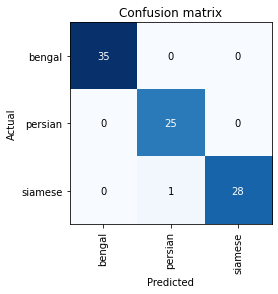

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

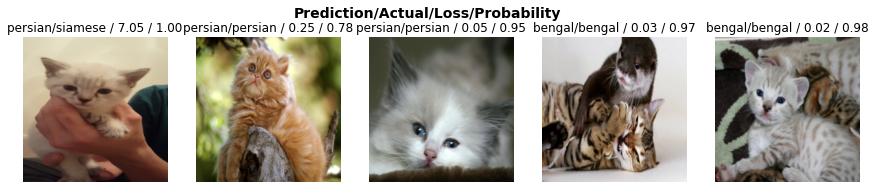

In [39]:
interp.plot_top_losses(5, nrows=1)

In [40]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [41]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [42]:
learn.export()

In [43]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [44]:
learn_inf = load_learner(path/'export.pkl')

In [46]:
learn_inf.predict('/content/gdrive//My Drive/Colab Notebooks/images/pers.jpg')

('persian', tensor(1), tensor([5.6009e-05, 9.9975e-01, 1.8986e-04]))

In [47]:
learn_inf.dls.vocab

['bengal', 'persian', 'siamese']

In [48]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [49]:
img = PILImage.create(btn_upload.data[-1])


In [50]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [51]:
pred,pred_idx,probs = learn_inf.predict(img)

In [52]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: persian; Probability: 1.0000')

In [53]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [54]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [55]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [57]:
#hide_output
VBox([widgets.Label('Nice cats!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [61]:
#hide
!pip install voila

In [65]:
!jupyter serverextension enable voila -sys-prefix

Enable a serverextension in configuration.

Usage
    jupyter serverextension enable [--system|--sys-prefix]

Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--debug
    set log level to logging.DEBUG (maximize logging output)
--sys-prefix
    Use sys.prefix as the prefix for installing server extensions
--user
    Perform the operation for the current user
--python
    Install from a Python package
--py
    Install from a Python package
--system
    Perform the operation system-wide
--config=<Unicode> (JupyterApp.config_file)
    Default: u''
    Full path of a config file.
--log-level=<Enum> (Application.log_level)
    Default: 30
    Choices: (0, 10, 20, 30, 40, 50, 'DEBUG', 'INFO', 'WARN', 'ERROR', 'CRITICAL')
    Set the log level by value or name.

To see all available configurables, use `--help-all`

Bad config encountered 